# Setup

## package imports

In [1]:
from dataset import download_dataset, generate_taxonomy_dataframe, BeetleSet, get_dataloaders, get_class_freqs_dict
from loss_functions import WeightedCCELoss, WeightedBCELoss, WeightedMSELoss, WeightedFocalLoss
from train import weighted_fit, weighted_test
from models import SequentialMultiTaskModel, SimpleMultiTaskModel, SkipMultiTaskModel, HiddenLayerModel

import torch
from torchvision.transforms import Compose, Resize, RandomVerticalFlip, RandomRotation, Normalize, ToTensor 
import torchvision
from transforms import RandomResizedCrop
import numpy as np
import matplotlib.pyplot as plt

import json
from pathlib import Path
import pandas as pd

import random
import os

## pipeline function supporting weighted training

In [2]:
def weighted_pipeline(model_constructor, aux_model_args, model_name, taxa, transforms, seed, batch_size, 
                      num_workers, device, num_epochs, loss_coefs= None, root = '../output/msc-thesis-22/models/', criterion_constructor = WeightedCCELoss, early_stopping = None, dataloader_seed = None, 
                      optimizer_eps = 1e-08, optimizer_lr = 0.001,  scheduler_gamma = 0.995, reduction = 'mean', 
                      weight_scheme = None, aux_criterion_args = {}, use_amp = True, use_scaler = True, pin_memory = True):
    download_dataset()
    
    tmap = {'subfamily':'0', 'tribe': '1', 'genus': '2', 'species': '3'}
    model_name_ext = model_name + '_' + ''.join([tmap[taxon] for taxon in taxa])
    Path(root + model_name_ext).mkdir(parents=True, exist_ok=True)
    
    generate_taxonomy_dataframe('data/beetles/taxonomy.csv', root + model_name_ext + 
                                '/taxonomy-modified.csv', drop_min=9)
    dataset= BeetleSet(csv_path=root + model_name_ext + '/taxonomy-modified.csv', taxa=taxa)
    dataloaders, dataset_sizes = get_dataloaders(dataset, 0.2, transforms, None, batch_size, 
                                                 num_workers, seed, dataloader_seed, pin_memory)
    if weight_scheme == 'icf':
        train_idxs = dataloaders['train'].dataset.dataset.indices
        class_freqs_dict = get_class_freqs_dict(taxa ,dataset.dataframe, train_idxs)
        class_freqs = []
        for taxon in taxa:
            keys, vals = zip(*class_freqs_dict[taxon].items())
            assert list(keys) == list(dataset.labels_dict[taxon].keys())
            class_freqs.append(torch.tensor(list(vals)))
        weights_per_taxon = [1.0/taxon_freqs for taxon_freqs in class_freqs]
    else:
        weights_per_taxon = None
        
    if weights_per_taxon is not None:
        assert len(weights_per_taxon) == len(taxa)
        for i, taxon in enumerate(taxa):
            assert torch.is_tensor(weights_per_taxon[i])
            assert len(weights_per_taxon[i].shape) == 1
            assert len(weights_per_taxon[i]) == len(dataset.labels_dict[taxon])
    
    if loss_coefs is not None:
        assert torch.is_tensor(loss_coefs)
        assert len(loss_coefs.shape) == 1
        assert len(loss_coefs) == len(taxa)
    else:
        loss_coefs = torch.ones(len(taxa))
        
    classes_per_taxon = [len(dataset.labels_dict[taxon]) for taxon in taxa]
    constructor_args = {**aux_model_args, **{'classes_per_taxon':classes_per_taxon}}
    model = model_constructor(**constructor_args).to(device)
    
    criterion_args = {**aux_criterion_args, **{'weights_per_taxon':weights_per_taxon}}
    criterion = criterion_constructor(**criterion_args)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=optimizer_lr, eps = optimizer_eps)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    
    if __name__ == '__main__':
        model, metrics = weighted_fit(model, criterion, optimizer, scheduler, dataloaders, taxa, dataset_sizes, 
                                      device, loss_coefs, num_epochs, plot_path = root + model_name_ext + '/metrics',
                                      early_stopping = early_stopping, reduction = reduction, use_amp = use_amp, 
                                      use_scaler= use_scaler)
    torch.save(model.state_dict(), root + model_name_ext + '/state_dict.pt')
    
    criterion.weights_per_taxon = None
    test_metrics = weighted_test(model, criterion, dataloaders['test'], device, 
                                 dataset_sizes, taxa)
    for taxon in taxa + ['total']:
        metrics[taxon]['test'] = test_metrics[taxon]
    
    metrics['model_type'] = str(type(model))
    metrics['classes_per_taxon'] = classes_per_taxon
    metrics['aux_model_args'] = {}
    
    for name, arg in aux_model_args.items():
        if name == 'hidden_features_per_taxon':
            metrics['aux_model_args'][name] = arg
        elif name == 'model':
            metrics['aux_model_args'][name] = str(type(arg))
        else:
            metrics['aux_model_args'][name] = str(arg)
     
    metrics['criterion_type'] = str(type(criterion))
    metrics['reduction'] = reduction
    metrics['weight_scheme'] = weight_scheme
    if weights_per_taxon is None:
        metrics['weights_per_taxon'] = weights_per_taxon
    else:
        metrics['weights_per_taxon'] = [tensor.tolist() for tensor in weights_per_taxon]
    for name, arg in aux_criterion_args.items():
        metrics['aux_criterion_args'][name] = arg
    
    metrics['optimizer_eps'] = optimizer_eps
    metrics['optimizer_lr'] = optimizer_lr
    metrics['scheduler_gamma'] = scheduler_gamma
    
    metrics['batch_size'] = batch_size
    
    metrics['seed'] = seed
    
    with open(root + model_name_ext + '/metrics.json', 'w') as file:
        json.dump(metrics, file, indent = 4)
    
    return model, metrics

## global parameters

In [3]:
models_root = '../output/msc-thesis-22/models/'
baseline_root = models_root + 'baseline/'
extensions_root =  models_root + 'extensions/'
custom_root = models_root + 'custom/'
relics_root = models_root + 'relics/'
taxa = ['subfamily', 'tribe', 'genus', 'species']
taxa_rev = taxa[::-1]
BEETLENET_MEAN = np.array([0.8442649, 0.82529384, 0.82333773], dtype=np.float32)
BEETLENET_STD = np.array([0.28980458, 0.32252666, 0.3240354], dtype=np.float32)
BEETLENET_AVERAGE_SHAPE = (224, 448)
default_transforms = [Compose([Resize(BEETLENET_AVERAGE_SHAPE), ToTensor(), Normalize(BEETLENET_MEAN, BEETLENET_STD)])] * 3
batch_size = 64
num_workers = 4
num_epochs = 400
seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
train_transforms = Compose([
    RandomVerticalFlip(p=0.5),
    RandomRotation((-3, 3), fill=255),
    RandomResizedCrop(min_scale=0.95, max_scale=1),
    Resize(BEETLENET_AVERAGE_SHAPE),
    ToTensor(),
    Normalize(BEETLENET_MEAN, BEETLENET_STD)])
modified_transforms = [train_transforms] + default_transforms[1:]

## reproducibility 

In [4]:
def seed_global(seed: int):
    #os.environ['PYTHONHASHSEED'] = str(seed) i am not sure about this one
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    #force pytorch to use deterministic algorithms for all operations when available, 
    # and throw and error when operations cannot be executed deterministically.
    #torch.use_deterministic_algorithms(True) 

def reset_seed(seed, resave = True):
    seed_global(seed)
    base_model = torchvision.models.resnet18(False)
    if os.path.exists(models_root +'init_weights.pt') and not(resave):
        init_weights = torch.load(models_root +'init_weights.pt')
        base_model.load_state_dict(init_weights)
    else:
        init_weights = base_model.state_dict()
        torch.save(init_weights, models_root +'init_weights.pt')
    return base_model

# Baseline experiments

## train a simple parallel multi-task model

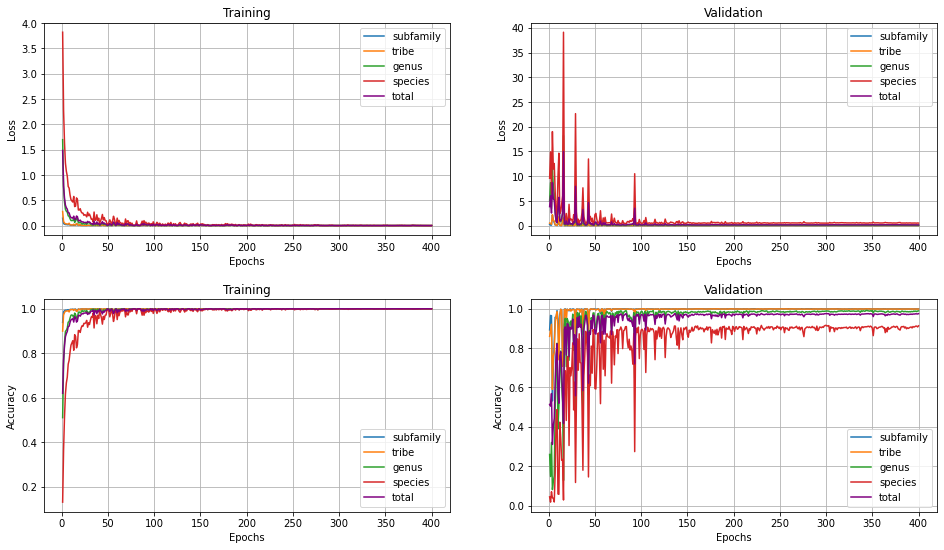

Training complete in 124m 12s
----------
Best validation epoch:   78
Best validation accuracy: 0.973970
Best validation loss: 0.109617



In [6]:
model_name = 'parallel'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = baseline_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

## train simple sequential multi-task models

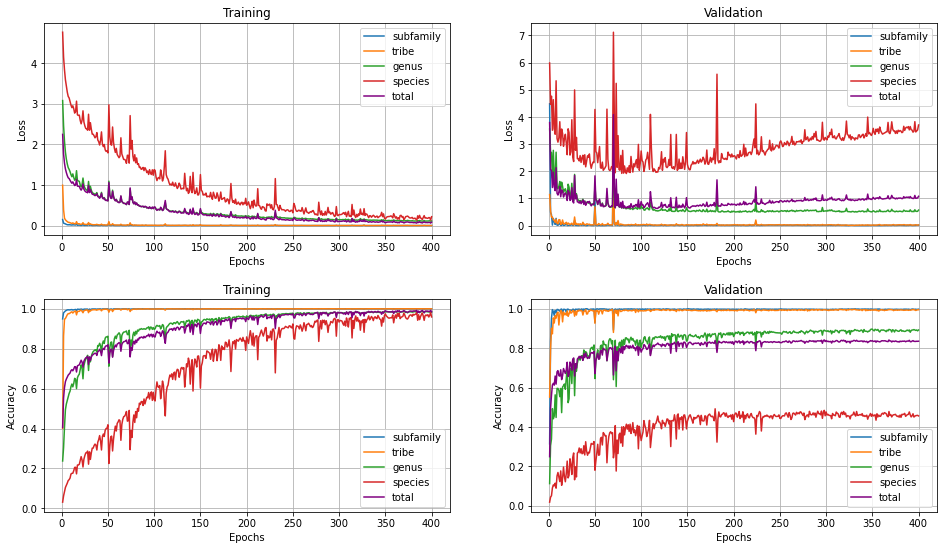

Training complete in 128m 5s
----------
Best validation epoch:  116
Best validation accuracy: 0.817426
Best validation loss: 0.632126



In [7]:
model_name = 'sequential'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = baseline_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

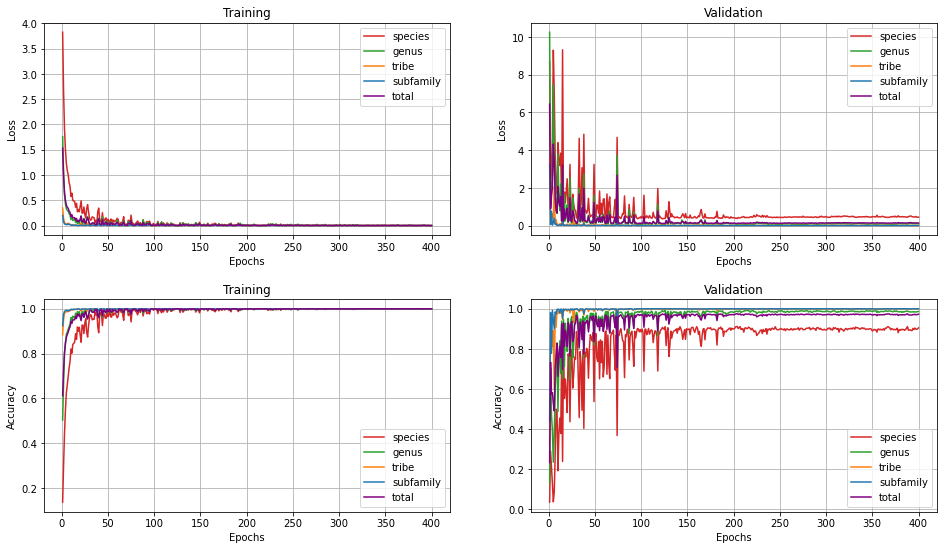

Training complete in 122m 10s
----------
Best validation epoch:   96
Best validation accuracy: 0.971620
Best validation loss: 0.107645



In [8]:
model_name = 'sequential'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = baseline_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

## Train single task models

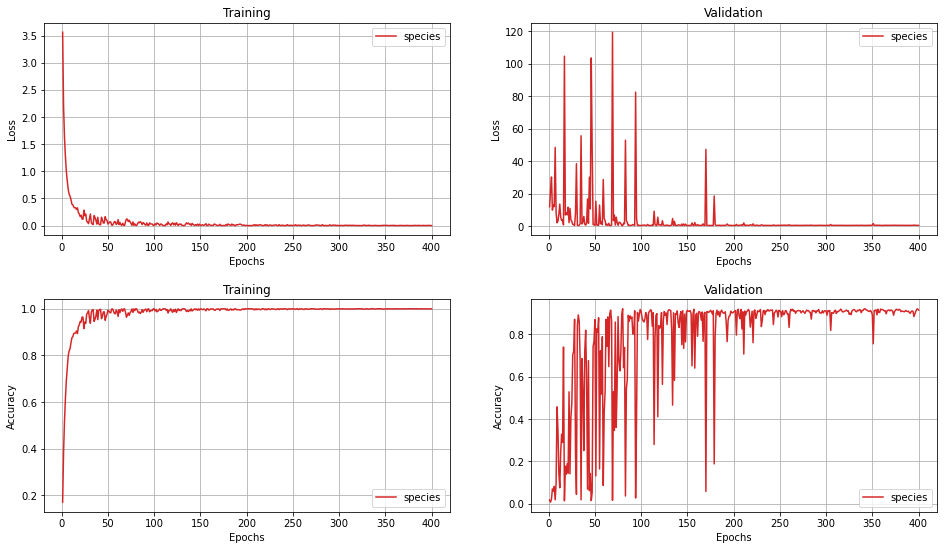

Training complete in 110m 57s
----------
Best validation epoch:   80
Best validation accuracy: 0.921186
Best validation loss: 0.379932



In [6]:
metrics_dict = {}
model_name = 'single'
model_constructor = SequentialMultiTaskModel
for taxon in taxa:
    base_model = torchvision.models.resnet18(False)
    constructor_args = {'model':base_model}
    model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, [taxon], default_transforms, 
                                        seed, batch_size, num_workers, device, num_epochs, root = baseline_root, 
                                        reduction = 'mean', criterion_constructor = WeightedCCELoss)
    metrics_dict[taxon] = metrics

## Save single task model training metrics in figure of subplots

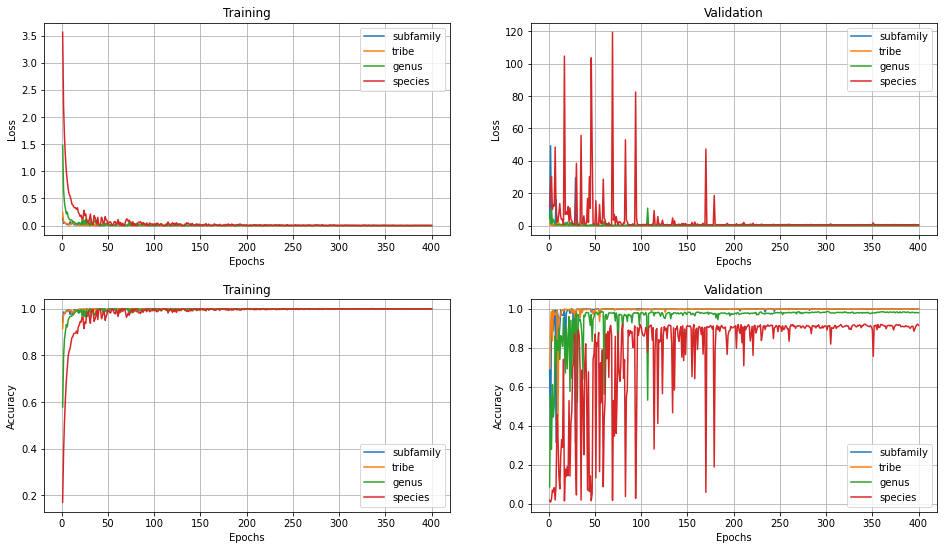

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16,9))
plt.subplots_adjust(hspace=.3)
for ax in axs.flat:
    ax.set_xlabel('Epochs')
    ax.grid()
for i in range(2):
    axs[0,i].set_ylabel('Loss')
    axs[1,i].set_ylabel('Accuracy')
    axs[i, 0].set_title('Training')
    axs[i, 1].set_title('Validation')
for i, loss_type in enumerate(['loss', 'acc']):
    for j, phase in enumerate(['train', 'val']):
        for taxon in taxa:
            metrics = metrics_dict[taxon]
            xs = metrics['epochs']
            ys = metrics[taxon][phase][loss_type]
            axs[i, j].plot(xs, ys, label=taxon)
        axs[i, j].legend()
        extent = axs[i, j].get_tightbbox(fig.canvas.get_renderer()).transformed(
            fig.dpi_scale_trans.inverted())
        Path(baseline_root +'single_comparison/').mkdir(exist_ok = True, parents = True)
        save_path =  baseline_root + 'single_comparison/' + loss_type + '_' + phase + '.png'
        fig.savefig(save_path, bbox_inches=extent.expanded(1.1,1.1), dpi=200, facecolor='w')
plt.show()
plt.close()

# Baseline extensions

## Sequential model extensions

### Add input reuse (skip-connections)

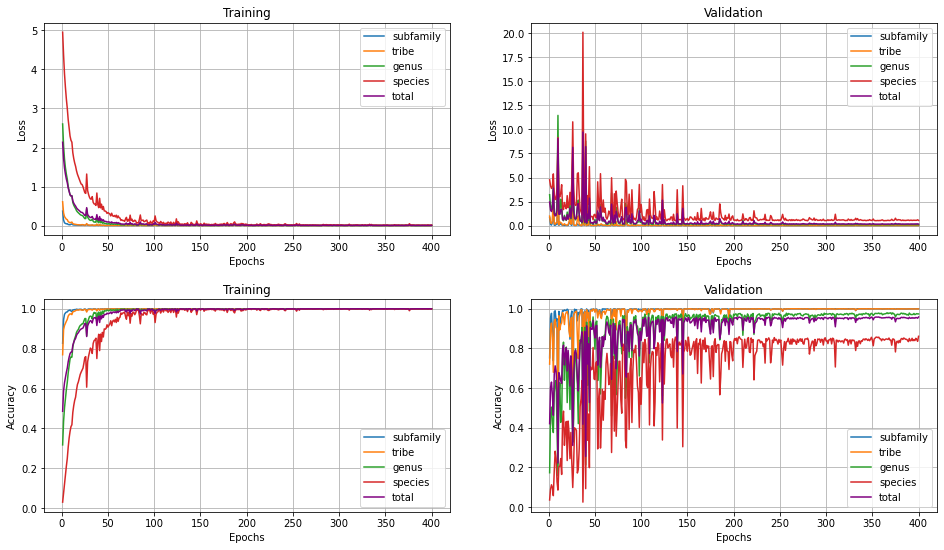

Training complete in 121m 21s
----------
Best validation epoch:  108
Best validation accuracy: 0.956978
Best validation loss: 0.140172



In [4]:
model_name = 'skip'
model_constructor = SkipMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedCCELoss)

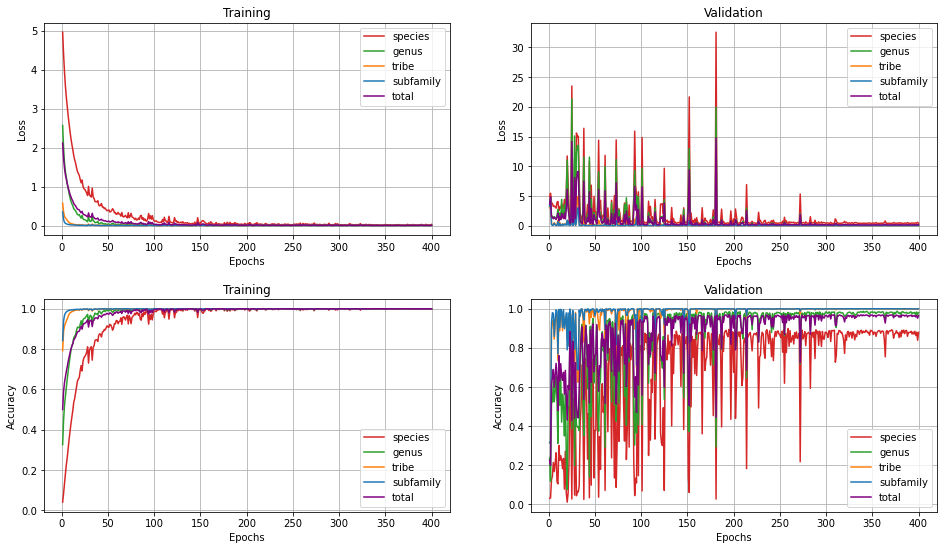

Training complete in 111m 27s
----------
Best validation epoch:  195
Best validation accuracy: 0.969812
Best validation loss: 0.104439



In [5]:
model_name = 'skip'
model_constructor = SkipMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedCCELoss)


### Add hidden layers

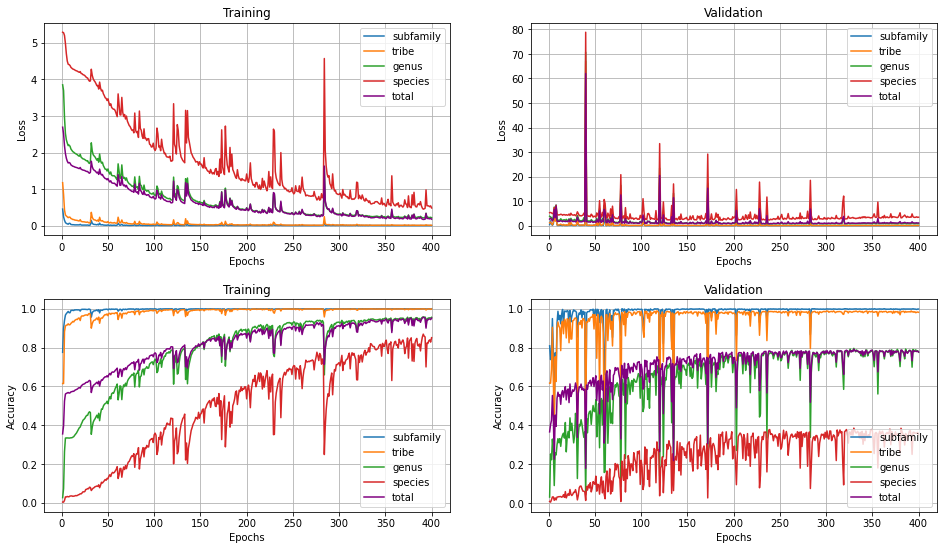

Training complete in 112m 12s
----------
Best validation epoch:  184
Best validation accuracy: 0.772415
Best validation loss: 0.757006



In [6]:
# in_features of fc layer in vanilla res-net18 == 512
# number of classes per taxonomical level == [2, 4, 44, 197]
hidden_features_per_taxon = [200, 3, 10, 100]
model_name = 'hidden'
model_constructor = HiddenLayerModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model, 'hidden_features_per_taxon': hidden_features_per_taxon}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedCCELoss)

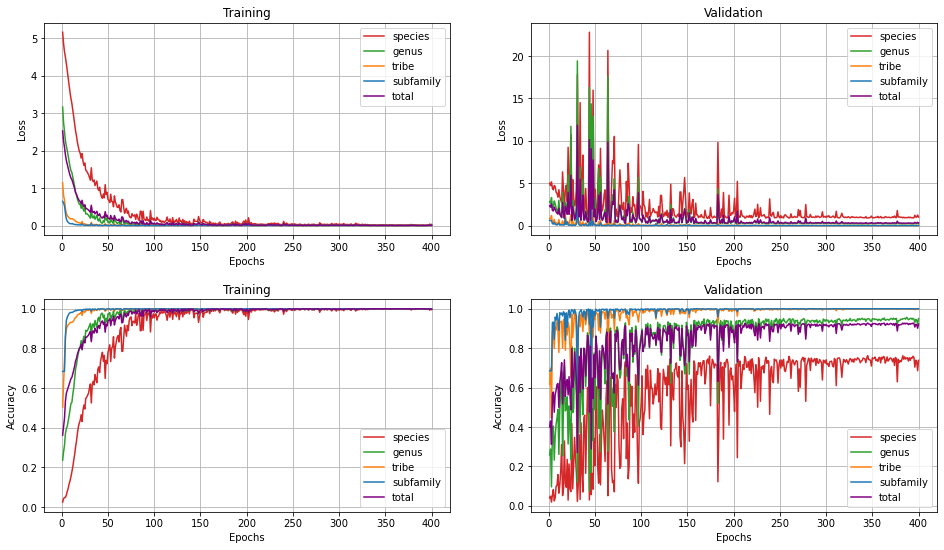

Training complete in 112m 21s
----------
Best validation epoch:  172
Best validation accuracy: 0.921909
Best validation loss: 0.260433



In [7]:
# in_features of fc layer in vanilla res-net18 == 512
# number of classes per taxonomical level == [197, 44, 4, 2]
hidden_features_per_taxon = [350, 100, 25, 3]
model_name = 'hidden'
model_constructor = HiddenLayerModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model, 'hidden_features_per_taxon': hidden_features_per_taxon}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedCCELoss)

## Experimenting with different loss functions

### (multi-class) focal loss

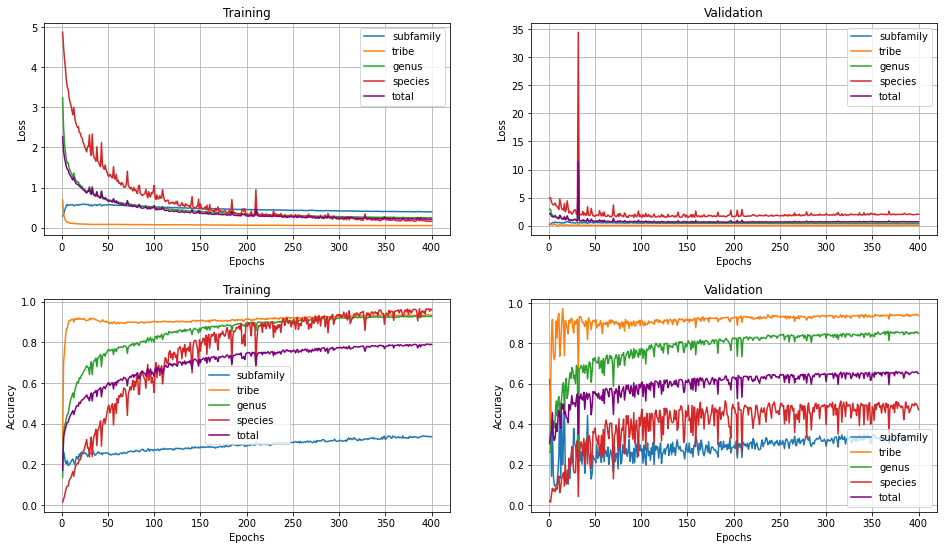

Training complete in 153m 39s
----------
Best validation epoch:  151
Best validation accuracy: 0.622379
Best validation loss: 0.641738



In [4]:
#focal_loss = torch.hub.load(
#	'adeelh/pytorch-multi-class-focal-loss',
#	model='FocalLoss',
#	gamma=2,
#)
model_name = 'fl_gamma_2'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
aux_model_args = {'model':base_model}
aux_criterion_args = {'gamma': 2.0}

model, metrics = weighted_pipeline(model_constructor, aux_model_args, model_name, taxa, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedFocalLoss, 
                                   aux_criterion_args=aux_criterion_args)

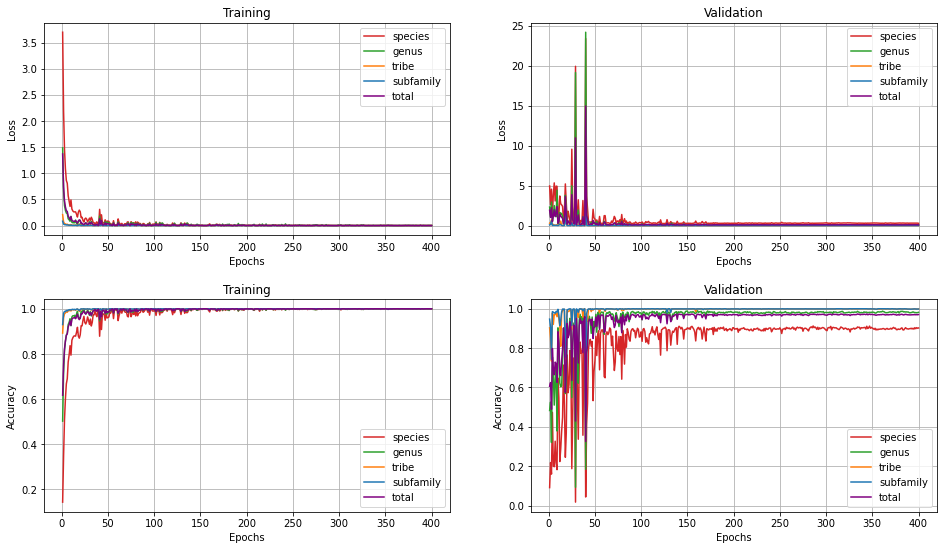

Training complete in 122m 33s
----------
Best validation epoch:  112
Best validation accuracy: 0.973970
Best validation loss: 0.076204



In [6]:
model_name = 'fl_gamma_1'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
aux_model_args = {'model': base_model}
aux_criterion_args = {'gamma': 1.0}

model, metrics = weighted_pipeline(model_constructor, aux_model_args, model_name, taxa, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedFocalLoss,
                                   aux_criterion_args=aux_criterion_args)


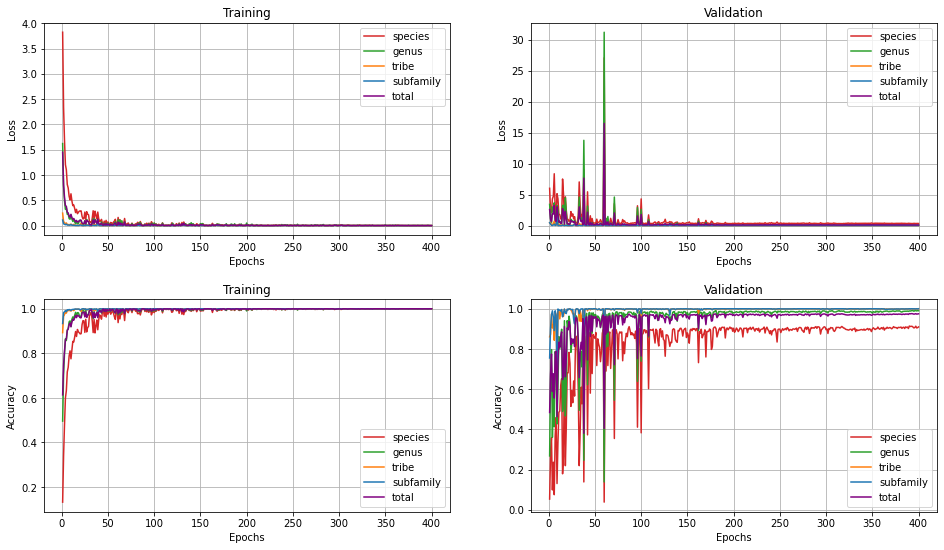

Training complete in 118m 11s
----------
Best validation epoch:   87
Best validation accuracy: 0.973427
Best validation loss: 0.092766



In [7]:
model_name = 'fl_gamma_05'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
aux_model_args = {'model': base_model}
aux_criterion_args = {'gamma': 0.5}

model, metrics = weighted_pipeline(model_constructor, aux_model_args, model_name, taxa, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedFocalLoss, 
                                   aux_criterion_args=aux_criterion_args)

### Binary cross entropy per class (treat as multi-label problem)

#### Mean aggregation 

In [ ]:
model_name = 'bce_mean_sequential'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedBCELoss)


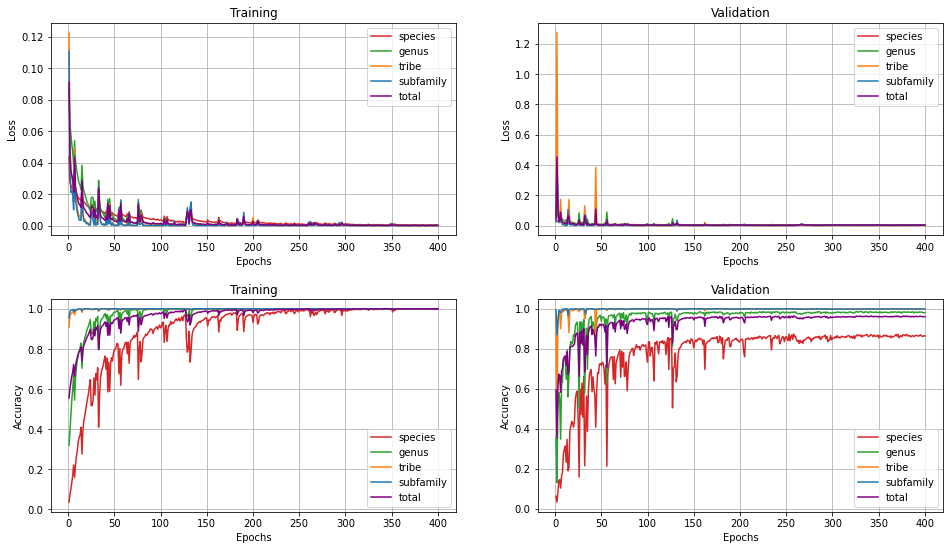

Training complete in 135m 13s
----------
Best validation epoch:  233
Best validation accuracy: 0.962581
Best validation loss: 0.002190



In [6]:
model_name = 'bce_mean_parallel'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = extensions_root, 
                                    reduction = 'mean', criterion_constructor = WeightedBCELoss)

#### Sum aggregation

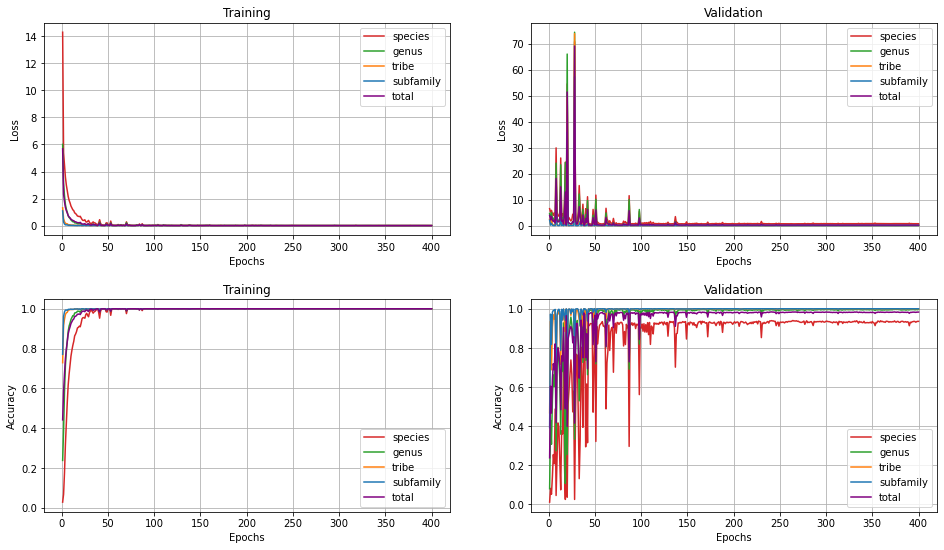

Training complete in 113m 42s
----------
Best validation epoch:   58
Best validation accuracy: 0.981923
Best validation loss: 0.177041



In [7]:
model_name = 'bce_sum_sequential'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='sum', criterion_constructor=WeightedBCELoss)

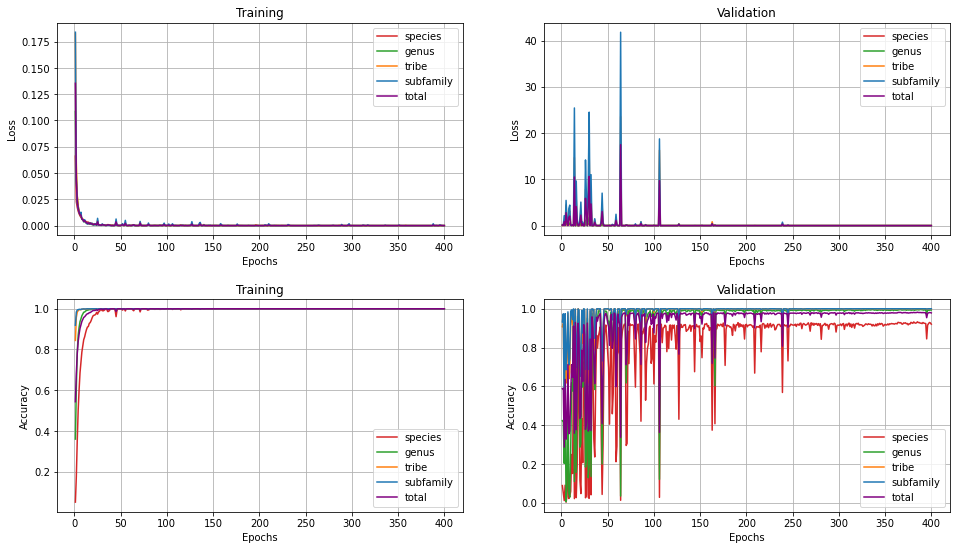

Training complete in 127m 48s
----------
Best validation epoch:   69
Best validation accuracy: 0.977947
Best validation loss: 0.001671



In [7]:
model_name = 'bce_sum_parallel'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = extensions_root, 
                                    reduction = 'sum', criterion_constructor = WeightedBCELoss)

In [ ]:
model_name = 'bce_sum_single'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, ['species'],
                                   default_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='sum', 
                                   criterion_constructor=WeightedBCELoss)

### CCE loss with sum reduction

In [ ]:
model_name = 'sequential_sum'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev,
                                   default_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='sum',
                                   criterion_constructor=WeightedCCELoss)

In [ ]:
model_name = 'parallel_sum'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev,
                                   default_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='sum',
                                   criterion_constructor=WeightedCCELoss)

### MSE loss

#### Sum aggregation

In [ ]:
model_name = 'mse_sum_sequential'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev,
                                   default_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='sum',
                                   criterion_constructor=WeightedMSELoss)


In [ ]:
model_name = 'mse_sum_parallel'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev,
                                   default_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='sum',
                                   criterion_constructor=WeightedMSELoss)


## Experimenting with different loss weighting schemes


### Inverse class frequency (ICF)


In [ ]:
model_name = 'sequential_icf'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedCCELoss, weight_scheme='icf')

In [ ]:
model_name = 'parallel_icf'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms,
                                   seed, batch_size, num_workers, device, num_epochs, root=extensions_root,
                                   reduction='mean', criterion_constructor=WeightedCCELoss, weight_scheme='icf')


### Per taxon weight scaling prioritizing species level

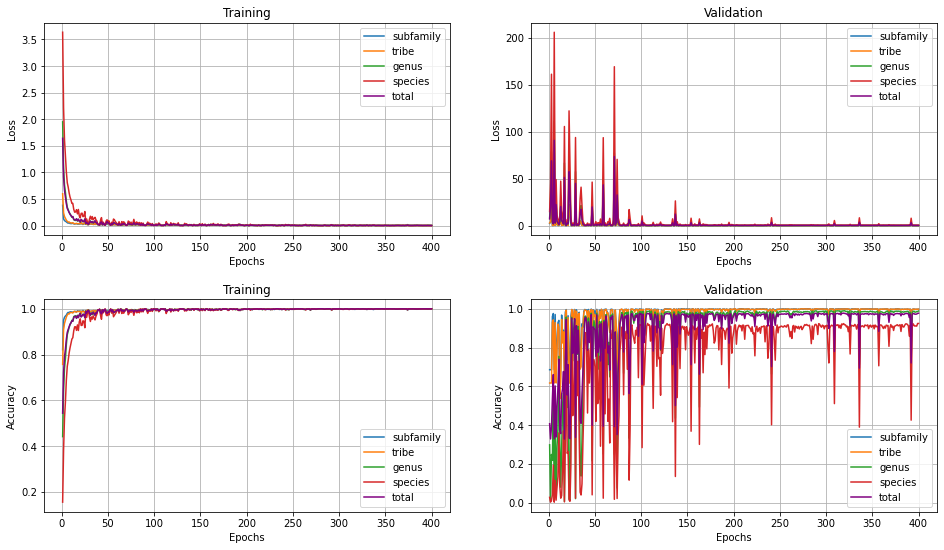

Training complete in 119m 2s
----------
Best validation epoch:   90
Best validation accuracy: 0.975054
Best validation loss: 0.113283



In [7]:
model_name = 'parallel_weighted'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
loss_coefs = torch.tensor([1.0, 10.0, 100.0, 1000.0])

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa,
                                    default_transforms, seed, batch_size, num_workers, device, 
                                    num_epochs, loss_coefs = loss_coefs, root = extensions_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

## Hyper parameter tuning

### Batch size 32

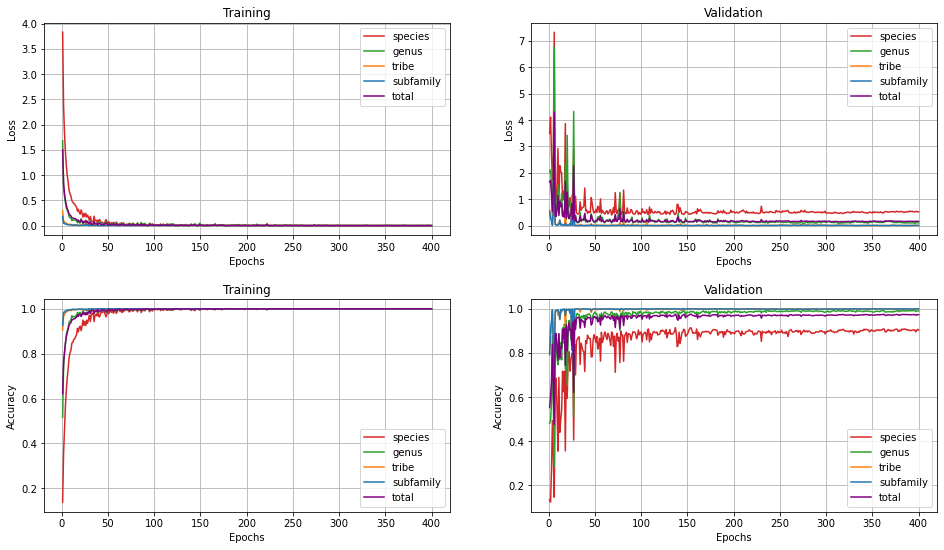

Training complete in 131m 10s
----------
Best validation epoch:   68
Best validation accuracy: 0.969812
Best validation loss: 0.129961



In [11]:
model_name = 'sequential_b32'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev,
                                   default_transforms, seed, 32, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='mean',
                                   criterion_constructor=WeightedCCELoss)

### Higher learning rate

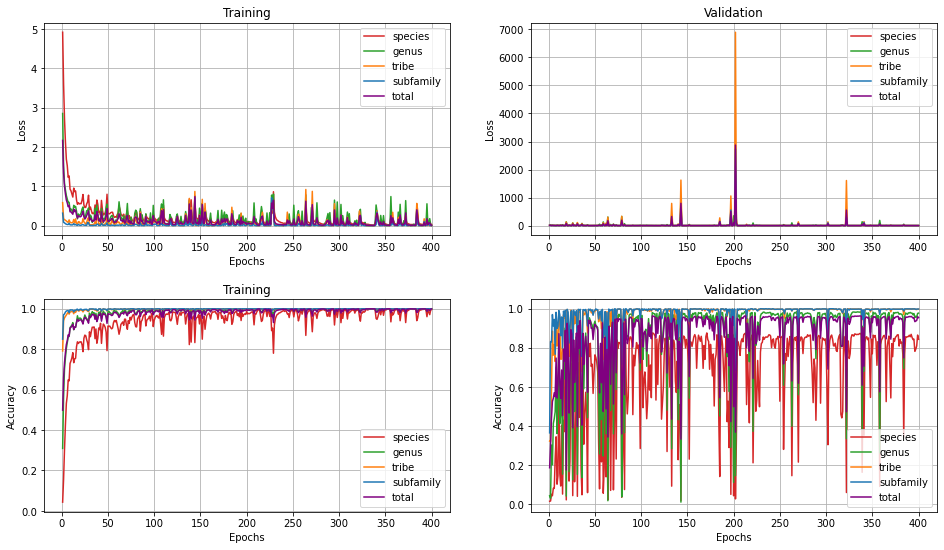

Training complete in 124m 54s
----------
Best validation epoch:   88
Best validation accuracy: 0.956797
Best validation loss: 0.234174



In [12]:
model_name = 'sequential_lr_001'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev,
                                   default_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='mean',
                                   criterion_constructor=WeightedCCELoss, 
                                   optimizer_lr=0.01, scheduler_gamma=0.9995)

### No exponential scheduler

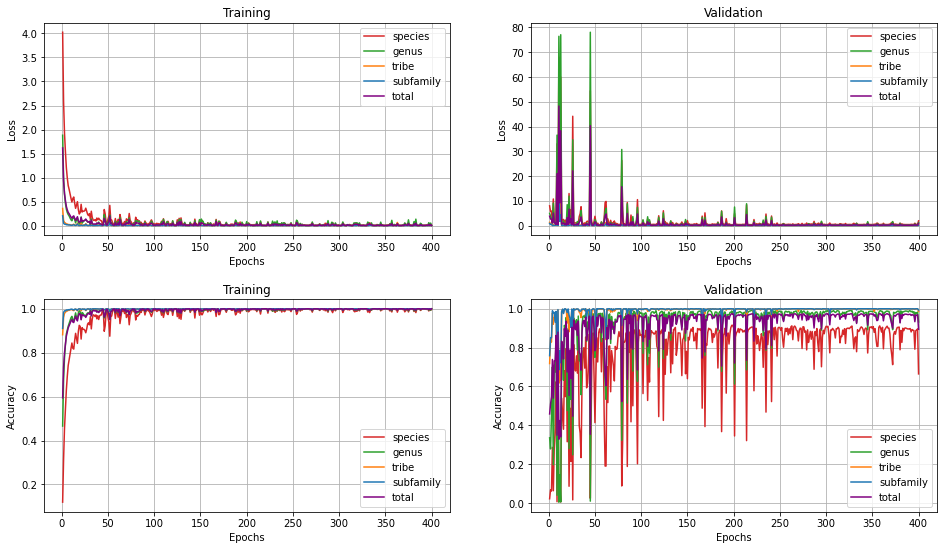

Training complete in 131m 29s
----------
Best validation epoch:  198
Best validation accuracy: 0.975597
Best validation loss: 0.113969



In [13]:
model_name = 'sequential_no_scheduler'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev,
                                   default_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='mean',
                                   criterion_constructor=WeightedCCELoss, scheduler_gamma = 1.0)


## Higher complexity ResNet Base models

### ResNet 34 base models

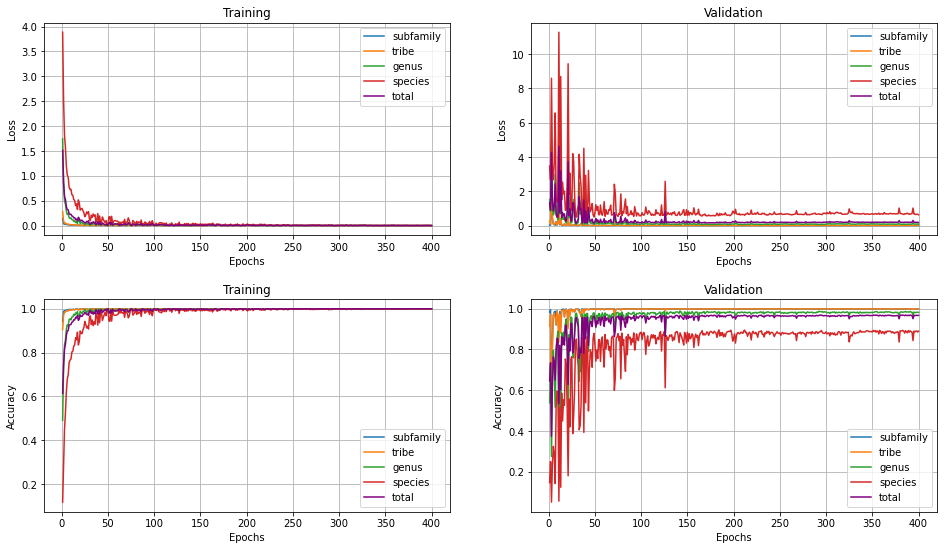

Training complete in 160m 47s
----------
Best validation epoch:   49
Best validation accuracy: 0.964389
Best validation loss: 0.144724



In [8]:
model_name = 'parallel_resnet34'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet34(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root =extensions_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

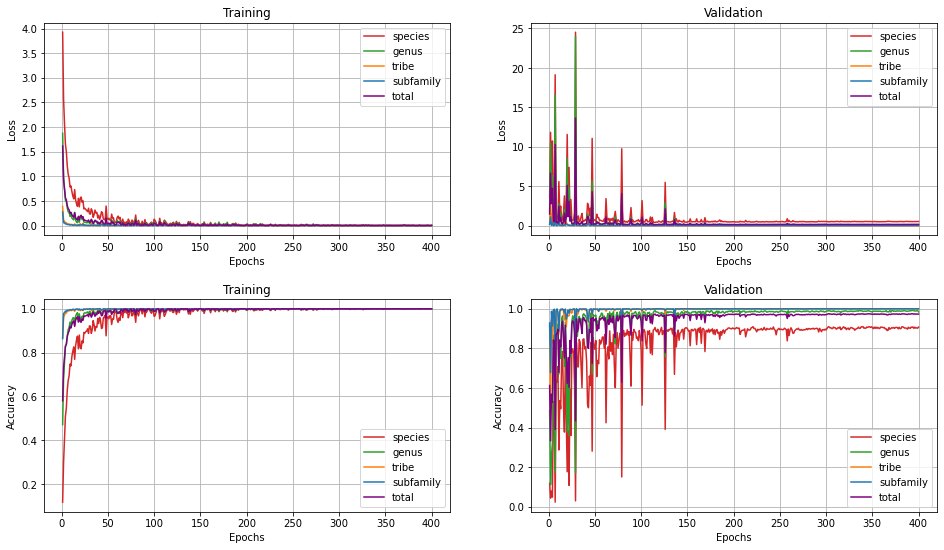

Training complete in 161m 6s
----------
Best validation epoch:  115
Best validation accuracy: 0.973247
Best validation loss: 0.116222



In [9]:
model_name = 'sequential_resnet34'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet34(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = extensions_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

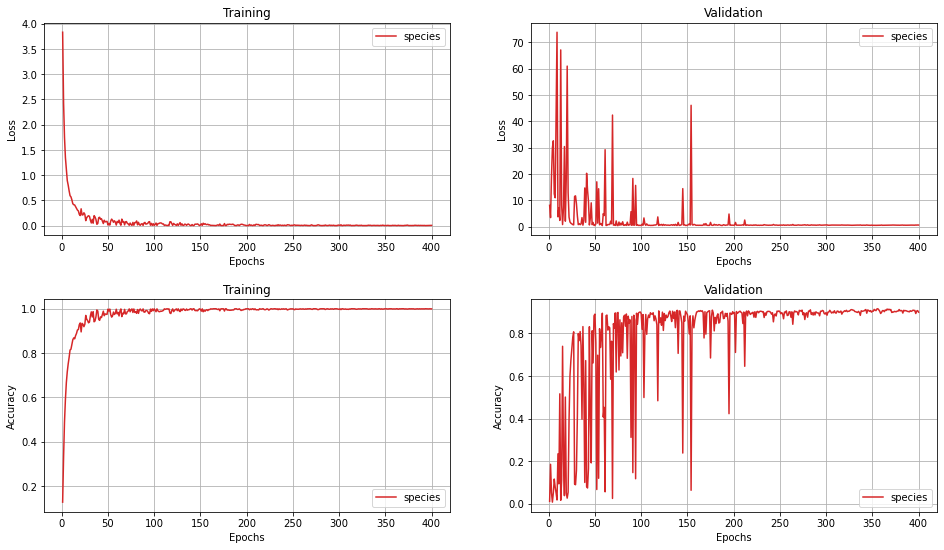

Training complete in 170m 29s
----------
Best validation epoch:   58
Best validation accuracy: 0.895156
Best validation loss: 0.471684



In [10]:
model_name = 'single_resnet34'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet34(False)
constructor_args = {'model':base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, ['species'],
                                    default_transforms, seed, batch_size, num_workers, device, 
                                    num_epochs, root = extensions_root, reduction = 'mean', 
                                    criterion_constructor = WeightedCCELoss)

### Resnet-50 base models

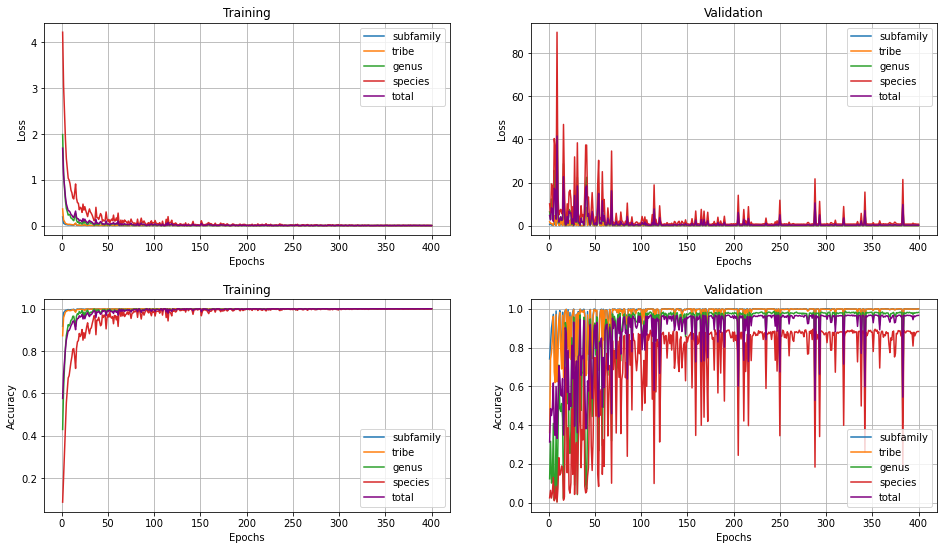

Training complete in 262m 3s
----------
Best validation epoch:  110
Best validation accuracy: 0.967643
Best validation loss: 0.150814



In [6]:
model_name = 'parallel_resnet50'
model_constructor = SimpleMultiTaskModel
base_model = torchvision.models.resnet50(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = extensions_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

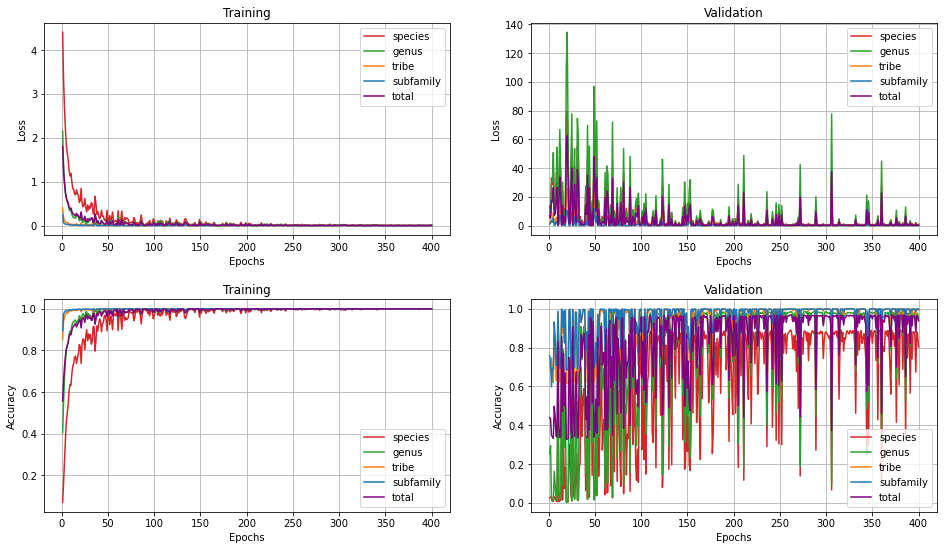

Training complete in 261m 26s
----------
Best validation epoch:  125
Best validation accuracy: 0.964570
Best validation loss: 0.162048



In [7]:
model_name = 'sequential_resnet50'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet50(False)
constructor_args = {'model':base_model}
model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, taxa_rev, default_transforms, 
                                    seed, batch_size, num_workers, device, num_epochs, root = extensions_root, 
                                    reduction = 'mean', criterion_constructor = WeightedCCELoss)

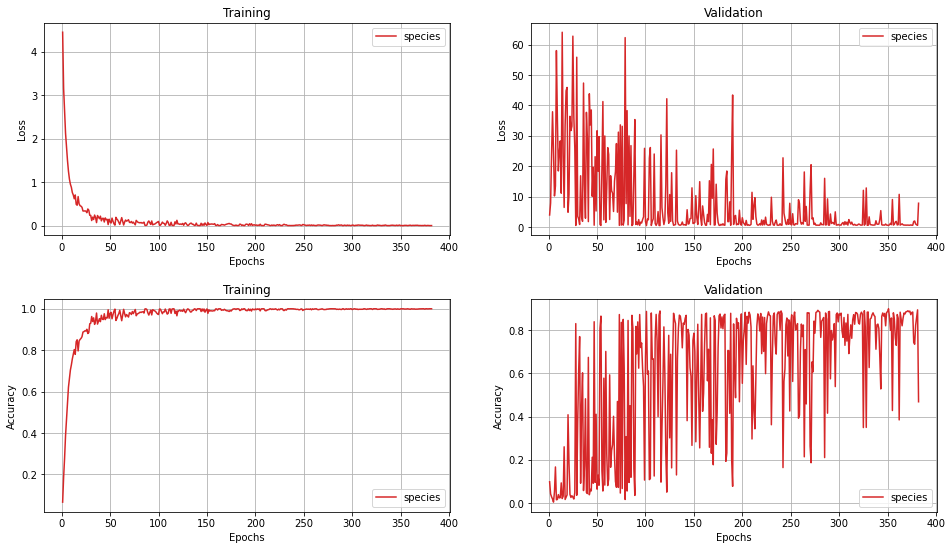

Epoch 382/400
----------
Train Loss: 0.0011 Acc: 0.9999
Val Loss: 7.8666 Acc: 0.4685



In [8]:
model_name = 'single_resnet50'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet50(False)
constructor_args = {'model':base_model}

model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, ['species'],
                                    default_transforms, seed, batch_size, num_workers, device, 
                                    num_epochs, root = extensions_root, reduction = 'mean', 
                                    criterion_constructor = WeightedCCELoss)

# Single task model with BCE loss (sum aggregation) and data augmentations

In [ ]:
model_name = 'bce_sum_augmentations_single'
model_constructor = SequentialMultiTaskModel
base_model = torchvision.models.resnet18(False)
constructor_args = {'model': base_model}


model, metrics = weighted_pipeline(model_constructor, constructor_args, model_name, ['species'],
                                   modified_transforms, seed, batch_size, num_workers, device,
                                   num_epochs, root=extensions_root, reduction='sum', criterion_constructor=WeightedBCELoss)

# Create table showing test accuracy of different models

In [7]:
model_info = []
model_info.append(('parallel', taxa, 'parallel', baseline_root))
model_info.append(('sequential',
                   taxa[::-1], 'r-sequential', baseline_root))
#model_info.append(('sequential',
                   #taxa, 'sequential', baseline_root))
for taxon in taxa:
    model_info.append(('single', [taxon], 'single-task', baseline_root))

#model_info.append(('skip', taxa[::-1], 'r-skip', extensions_root))
#model_info.append(('skip', taxa, 'skip', extensions_root))
#model_info.append(('hidden', taxa[::-1], 'r-hidden', extensions_root))
#model_info.append(('hidden', taxa, 'hidden', extensions_root))


In [8]:
test_accs = {}
for model_name, taxa_mod, df_name, root_mod in model_info:
    tmap = {'subfamily':'0', 'tribe': '1', 'genus': '2', 'species': '3'}
    model_name_ext = model_name + '_' + ''.join([tmap[taxon] for taxon in taxa_mod])
    with open(root_mod + model_name_ext + '/metrics.json') as file:
        metrics = json.load(file)
    if not df_name in test_accs:
        test_accs[df_name] = {}
    for taxon_mod in taxa_mod:
        test_accs[df_name][taxon_mod] = metrics[taxon_mod]['test']['acc']

In [11]:
df = pd.DataFrame.from_dict(test_accs)
df_base = df.iloc[:,:4]
latex_file = open('../report/chapters/basic_multi_task_models/results.tex', 'a')
latex_caption = 'Test set accuracy per taxonomical level for each baseline model'
latex_label = 'table:baseline_test_accuracy'
#latex_headers = ['$ \\bm{M_{\mathrm{parallel}}}$', '$ \\bm{M_{\mathrm{r-sequential}}}$',
                 #'$ \\bm{M_{\mathrm{sequential}}}$', '$ \\bm{S_1-S_4}$'] # for some reason the implementation does not escape \b as it should
latex_headers = ['$ \\bm{M_{\mathrm{parallel}}}$', '$ \\bm{M_{\mathrm{r-sequential}}}$', 
                 '$ \\bm{S_1-S_4}$'] # for some reason the implementation does not escape \b as it should
latex_df = df_base.copy()
latex_df.columns = latex_headers
latex_df.to_latex(latex_file, bold_rows=True, caption = latex_caption, label = latex_label, 
            escape = False, multicolumn_format='lcccc', column_format = 'lcccc')
df_base


,parallel,r-sequential,single-task
subfamily,0.999277,0.998554,0.997831
tribe,0.999277,0.997831,0.995662
genus,0.984093,0.984816,0.979031
species,0.912509,0.907448,0.917571


In [14]:
'''df_ext = df.iloc[:,4:8]

latex_caption = 'Test set accuracy per taxonomical level for extensions to sequential model'
latex_label = 'table:sequential_ext_test_accuracy'
latex_headers = ['$ \\bm{M_{\mathrm{r-skip}}}$', '$ \\bm{M_{\mathrm{skip}}}$',
                  '$ \\bm{M_{\mathrm{r-hidden}}}$', '$ \\bm{M_{\mathrm{hidden}}}$']
latex_df = df_ext.copy()
latex_df.columns = latex_headers
latex_df.to_latex(latex_file, bold_rows=True, caption = latex_caption, label = latex_label, 
            escape = False, multicolumn_format='lcccc', column_format = 'lcccc')
df_ext'''
pass